# Combinations
It seems that windows_size = 120, rebalance_period = 1 and max_selected_stocks = 100 offers over 20% annual return over 14 years.

I'll try out more combinations tomorrow... (Or is it today already???)

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set the directory and initial capital
directory = "/home/jesse/Projects/CWP_RL/02_MVO_Multi_Assets/SP500_10_25"
initial_capital = 10000
min_data_length = 2500  # At least 2500 rows of data
window_size = 120  # Number of days to use for calculating MVO
rebalance_period = 1  # Rebalance the portfolio every 1 day
max_selected_stocks = 100  # Maximum number of stocks to hold

print("✅ Initialization complete!")


✅ Initialization complete!


In [2]:
def load_data(directory):
    stock_data = {}
    for ticker in os.listdir(directory):
        if ticker.endswith(".csv"):
            file_path = os.path.join(directory, ticker)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.sort_index(inplace=True)

            # Only select stocks with enough data (>= min_data_length)
            if df.shape[0] >= min_data_length:
                # Store both Open and Close prices for each stock
                stock_data[ticker.replace(".csv", "")] = df[['Open', 'Close']]
    
    return stock_data

# Load the stock data
stock_data = load_data(directory)

# Preview the data of the first 5 stocks
for ticker in list(stock_data.keys())[:5]:
    print(f"📈 Sample data for {ticker}:\n", stock_data[ticker].head())

print(f"\n✅ Successfully loaded data for {len(stock_data)} stocks!")


📈 Sample data for TMUS:
                  Open      Close
Date                            
2010-12-31  20.499198  20.466789
2011-01-03  20.677453  21.179804
2011-01-04  21.520106  22.557220
2011-01-05  22.362759  23.108185
2011-01-06  21.082575  21.552517
📈 Sample data for CHRW:
                  Open      Close
Date                            
2010-12-31  57.084400  57.277256
2011-01-03  57.791513  58.220074
2011-01-04  57.370102  57.462955
2011-01-05  56.577250  57.055809
2011-01-06  56.991537  56.884396
📈 Sample data for COO:
                  Open      Close
Date                            
2010-12-31  13.984344  14.016686
2011-01-03  14.106250  14.143567
2011-01-04  14.178401  14.029128
2011-01-05  14.014200  13.947027
2011-01-06  13.927124  13.947027
📈 Sample data for ES:
                  Open      Close
Date                            
2010-12-31  19.867463  19.743599
2011-01-03  19.848883  19.786953
2011-01-04  19.842695  19.755991
2011-01-05  19.700245  19.502066
2011-01-06  

In [3]:
# Initialize an empty list to store returns for each stock
returns_list = []

for ticker in stock_data:
    # Get the daily returns for 'Close' prices
    stock_returns = stock_data[ticker].pct_change().dropna()
    
    # Add the 'Close' returns to the list
    returns_list.append(stock_returns['Close'])

# Concatenate all the returns DataFrames along columns (axis=1)
returns = pd.concat(returns_list, axis=1)

# Set column names as stock tickers
returns.columns = stock_data.keys()

# Preview the data
print("📊 Example of returns data (first 5 rows):\n", returns.head())

print("\n✅ Daily returns calculation completed!")


📊 Example of returns data (first 5 rows):
                 TMUS      CHRW       COO        ES      HSIC      MKTX  \
Date                                                                     
2011-01-03  0.034838  0.016461  0.009052  0.002196  0.022642 -0.015857   
2011-01-04  0.065034 -0.013004 -0.008091 -0.001565 -0.011787 -0.034180   
2011-01-05  0.024425 -0.007085 -0.005852 -0.012853 -0.000645  0.003034   
2011-01-06 -0.067321 -0.003004  0.000000 -0.001270  0.010645  0.026714   
2011-01-07 -0.026316 -0.001005  0.000178  0.005724 -0.001756 -0.006382   

                 UDR        ED      MCHP       EOG  ...       EMN       KEY  \
Date                                                ...                       
2011-01-03  0.014881 -0.000403  0.016954  0.010283  ...  0.015105  0.023729   
2011-01-04 -0.031420  0.003027 -0.002012 -0.002274  ...  0.017575 -0.011037   
2011-01-05 -0.008651 -0.006640  0.002880  0.002062  ...  0.007369  0.006696   
2011-01-06 -0.007417 -0.001013  0.005744  0

In [4]:
# Calculate annualized returns
def annualized_returns(returns, trading_days=252):
    return returns.mean() * trading_days

# Calculate the annualized covariance matrix
def annualized_covariance(returns, trading_days=252):
    return returns.cov() * trading_days

# Objective function: Maximize Sharpe Ratio
def objective(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.sum(weights * mean_returns)
    
    # Calculate portfolio volatility (standard deviation)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Handle negative or NaN variance (safety check)
    if portfolio_variance < 0 or np.isnan(portfolio_variance):
        portfolio_volatility = 1e-6  # A small value to avoid sqrt calculation error
    else:
        portfolio_volatility = np.sqrt(portfolio_variance)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return -sharpe_ratio  # Since `minimize` is minimizing, return the negative of the Sharpe Ratio

print("✅ MVO related functions have been defined!")


✅ MVO related functions have been defined!


In [5]:
# Initialize
portfolio_value = initial_capital
portfolio_values = []
weights_history = []

rebalance_dates = []  # Store the dates of each rebalance

for i in range(window_size, len(returns), rebalance_period):
    # Record the rebalance date (use i-1, as it refers to the data from the previous day)
    rebalance_dates.append(returns.index[i - 1])  

    # Get window data
    window_returns = returns.iloc[i - window_size:i]

    # Calculate annualized returns and standard deviation
    mean_returns = annualized_returns(window_returns)
    std_returns = window_returns.std() * np.sqrt(252)  # Annualized standard deviation

    # Calculate Sharpe Ratio and select the top max_selected_stocks stocks
    sharpe_ratios = mean_returns / std_returns
    top_stocks = sharpe_ratios.nlargest(max_selected_stocks).index  # Select the top max_selected_stocks stocks

    # Perform MVO only for selected stocks
    selected_returns = window_returns[top_stocks]
    mean_returns = mean_returns[top_stocks]
    cov_matrix = annualized_covariance(selected_returns)

    # Add a regularization term to prevent singular covariance matrix
    cov_matrix += np.eye(len(mean_returns)) * 1e-6  

    # Initialize weights
    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds for weights (0 ~ 1)
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Perform optimization
    optimized_result = minimize(objective, initial_weights, args=(mean_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

    # Get optimal weights
    optimal_weights = optimized_result.x
    weights_history.append(pd.Series(optimal_weights, index=top_stocks, name=returns.index[i - 1]))

    # Calculate portfolio return (based on actual returns for the next period)
    recent_returns = returns.iloc[i:i + rebalance_period][top_stocks].mean()
    portfolio_return = np.sum(optimal_weights * recent_returns)
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)

# Link portfolio values with dates
portfolio_results = pd.DataFrame({'Date': rebalance_dates, 'Portfolio Value': portfolio_values})

# Record portfolio weights
weights_df = pd.DataFrame(weights_history)

print("✅ MVO Calculation Complete, Dates and Weights Recorded!")

# Print Results
print(portfolio_results.head())
print(weights_df.head())


✅ MVO Calculation Complete, Dates and Weights Recorded!
        Date  Portfolio Value
0 2011-06-23      9978.011476
1 2011-06-24     10043.819527
2 2011-06-27     10219.949075
3 2011-06-28     10310.414347
4 2011-06-29     10517.003423
                ULTA       DPZ           OKE       HUM      CHTR  \
2011-06-23  0.070468  0.099361  1.301552e-13  0.042206  0.202940   
2011-06-24  0.067599  0.102790  6.257481e-14  0.025595  0.196178   
2011-06-27  0.054881  0.106476  1.367056e-13  0.019502  0.171574   
2011-06-28  0.000006  0.000002  4.005231e-06  0.000003  0.000004   
2011-06-29  0.002091  0.183901  8.526997e-09  0.009438  0.003855   

                     ELV      MNST           UNH      CTRA      BIIB  ...  \
2011-06-23  0.000000e+00  0.028872  1.052705e-15  0.045390  0.073328  ...   
2011-06-24  0.000000e+00  0.056966  0.000000e+00  0.042101  0.085649  ...   
2011-06-27  3.966359e-14  0.075910  3.363832e-14  0.050956  0.086595  ...   
2011-06-28  2.511067e-06  0.000006  1.661031e-0

In [6]:
# Generate DataFrame for weights and portfolio values
weights_df = pd.DataFrame(weights_history)
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=weights_df.index)

# Save results
weights_df.to_csv("optimal_weights_history.csv")
portfolio_values_df.to_csv("portfolio_value_history.csv")

print("✅ Results have been saved!")


✅ Results have been saved!


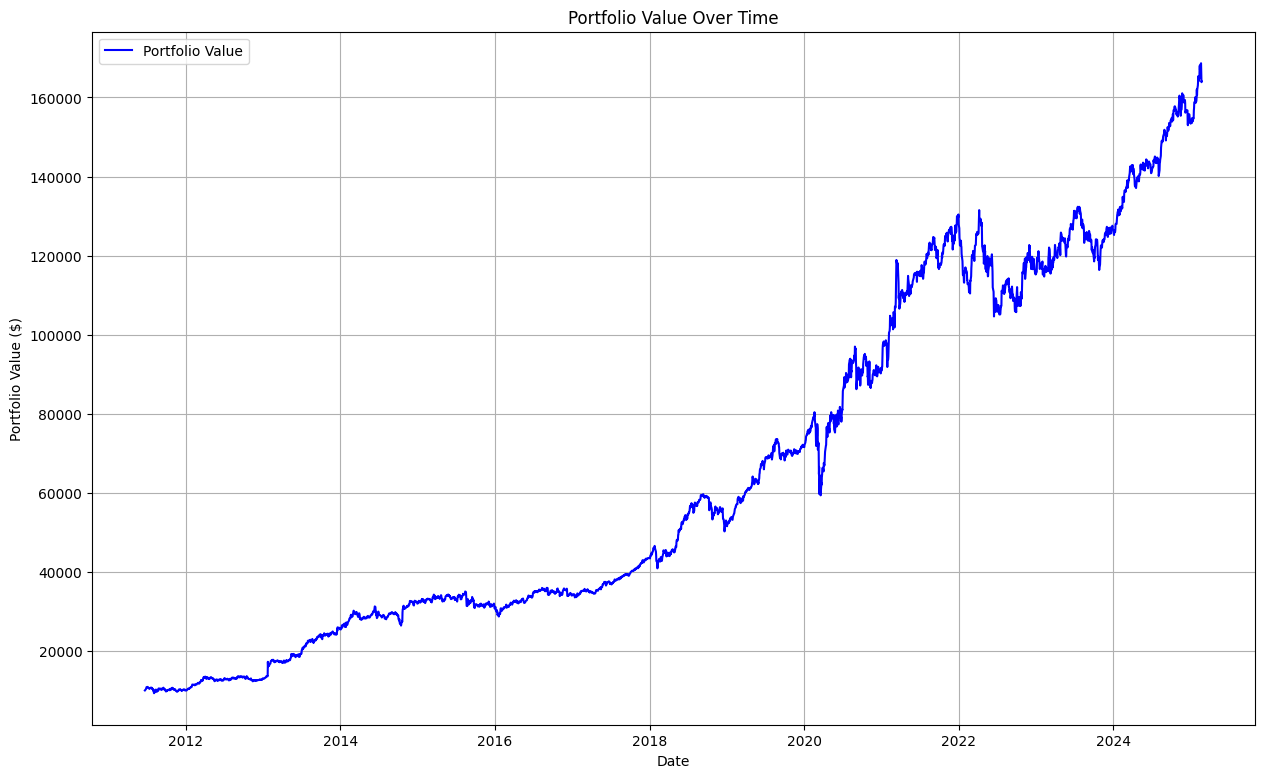

✅ Graph Finished


In [7]:
# Create MVO Portfolio Returns
plt.figure(figsize=(15, 9))
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], label='Portfolio Value', color='b')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("✅ Graph Finished")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


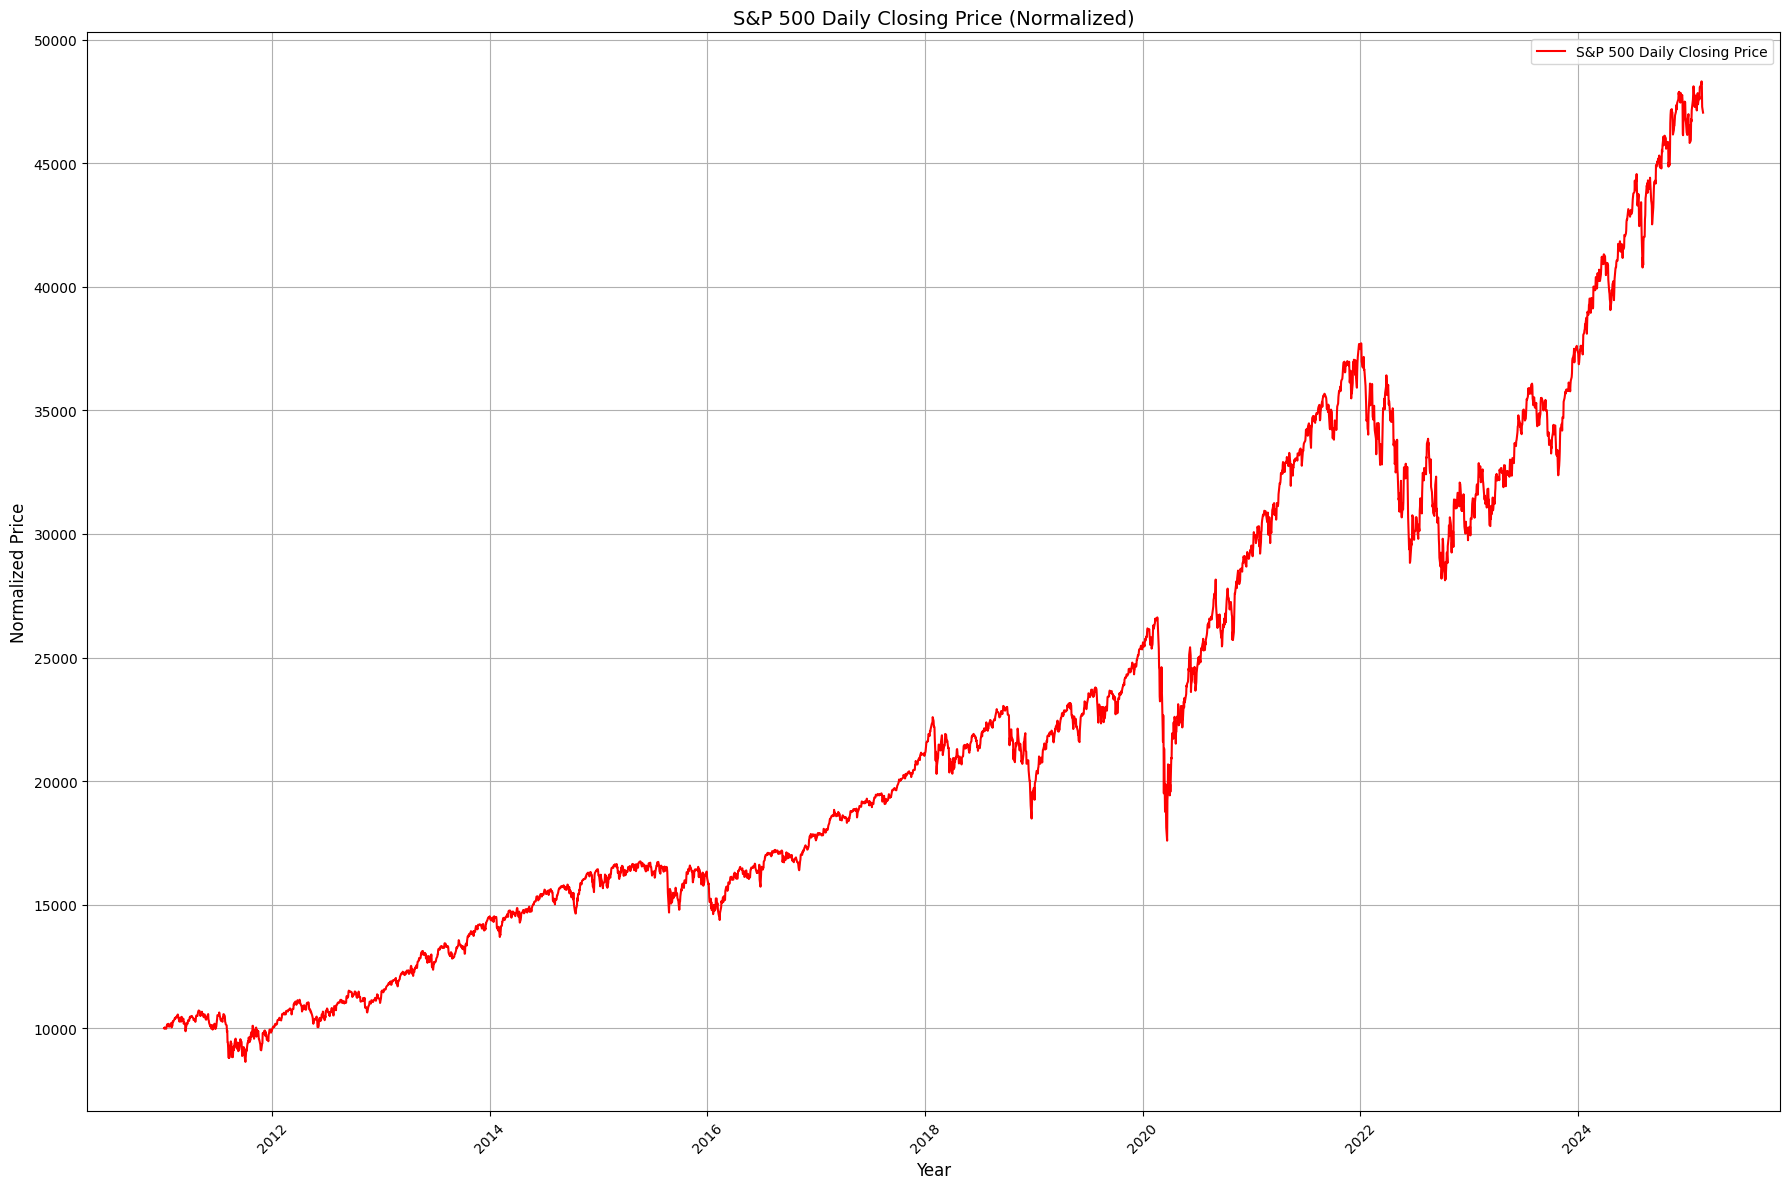

In [8]:
import matplotlib.dates as mdates
import yfinance as yf

# Download S&P 500 daily closing price data
data = yf.download('^GSPC', start='2011-01-03', end='2025-02-25')

# Get closing prices
close_prices = data['Close']

# Normalize closing prices: set the starting point to 10,000
normalized_close = 10000 * (close_prices / close_prices.iloc[0])

# Create chart
plt.figure(figsize=(18, 12))
plt.plot(close_prices.index, normalized_close, label='S&P 500 Daily Closing Price', color='r')

# Set x-axis to years
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.title('S&P 500 Daily Closing Price (Normalized)', fontsize=14)

# Format x-axis: display a tick every 2 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # One tick every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only the year

# Beautify the plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate ticks to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
